In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Part I: Image Cartoonifying 
# ============================================

def cartoonify_image(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Step 1: Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Apply median blur
    smoothed_gray = cv2.medianBlur(gray_image, 5)
    
    # Step 3: Laplacian edge detection
    laplacian = cv2.Laplacian(smoothed_gray, cv2.CV_8U, ksize=5)
    
    # Step 4: Thresholding to create sketch
    _, sketch = cv2.threshold(laplacian, 50, 255, cv2.THRESH_BINARY_INV)
    
    # Step 5: Bilateral filter for color smoothing
    color_smoothed = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Step 6: Combine sketch and color image
    cartoon = cv2.bitwise_and(color_smoothed, color_smoothed, mask=sketch)

    # Display all intermediate steps using matplotlib
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale Image")
    
    plt.subplot(2, 3, 3)
    plt.imshow(smoothed_gray, cmap='gray')
    plt.title("Median Filter Applied")
    
    plt.subplot(2, 3, 4)
    plt.imshow(laplacian, cmap='gray')
    plt.title("Laplacian Edges")
    
    plt.subplot(2, 3, 5)
    plt.imshow(sketch, cmap='gray')
    plt.title("Thresholded Sketch")
    
    plt.subplot(2, 3, 6)
    plt.imshow(cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB))
    plt.title("Final Cartoon Image")
    
    plt.tight_layout()
    plt.savefig("cartoon_steps.jpg")
    plt.show()



In [2]:
# ============================================
# Part II: Lane Detection (with detailed steps)
# ============================================

def detect_lanes(image_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Step 1: Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Median blur
    smoothed_gray = cv2.medianBlur(gray_image, 5)
    
    # Step 3: Canny edge detection
    edges = cv2.Canny(smoothed_gray, 50, 150)
    
    # Step 4: Region of Interest (ROI) masking
    height, width = edges.shape
    mask = np.zeros_like(edges)
    vertices = np.array([[(0, height), (width//2, height//2), (width, height)]], dtype=np.int32)
    cv2.fillPoly(mask, [vertices], 255)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Step 5: Hough Transform
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=50, 
                           minLineLength=50, maxLineGap=20)
    
    # Step 6: Draw lines
    line_image = np.copy(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

    # Display all steps
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    
    plt.subplot(2, 3, 2)
    plt.imshow(smoothed_gray, cmap='gray')
    plt.title("Smoothed Grayscale")
    
    plt.subplot(2, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edges")
    
    plt.subplot(2, 3, 4)
    plt.imshow(masked_edges, cmap='gray')
    plt.title("ROI Masked Edges")
    
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Lanes")
    
    plt.tight_layout()
    plt.savefig("lane_steps.jpg")
    plt.show()



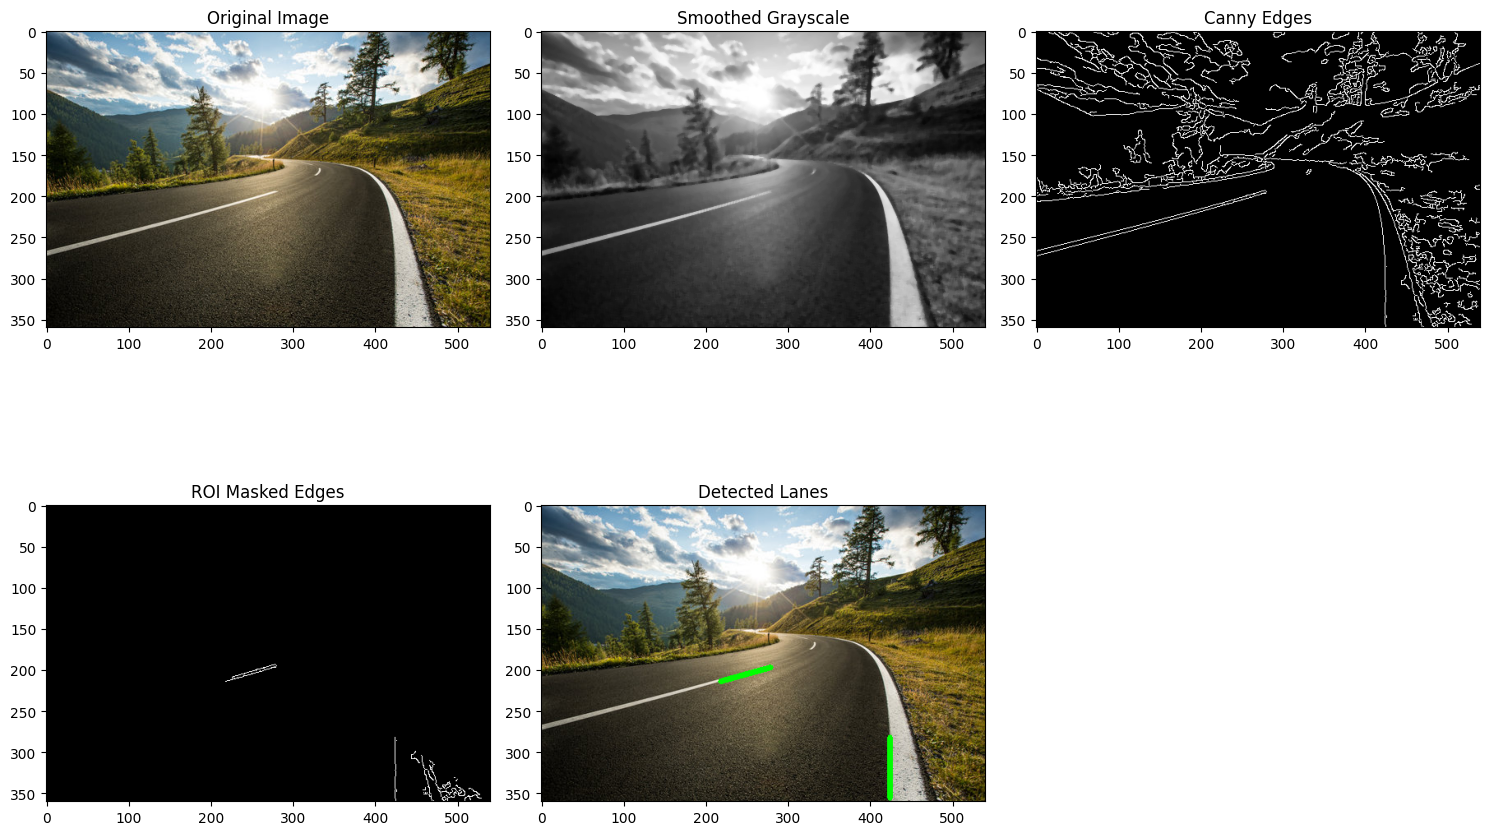

In [5]:
# ============================================
# Main Program
# ============================================

if __name__ == "__main__":
    #cartoonify_image("robert.webp")
    detect_lanes("test_images/road1.jpg")

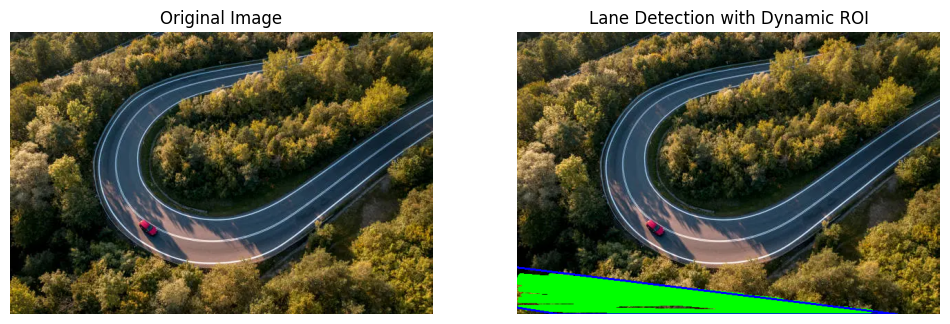

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_vanishing_point(edges):
    """
    Detects the vanishing point by finding the intersection of lane lines using the Hough Transform.
    """
    # Detect lines using the Hough Transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)
    
    if lines is None:
        return None  # No vanishing point detected

    # Convert lines into slope-intercept form: y = mx + b
    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:  # Avoid division by zero (vertical lines)
            continue
        m = (y2 - y1) / (x2 - x1)  # Slope
        b = y1 - m * x1  # Intercept
        slopes.append(m)
        intercepts.append(b)

    # Find intersections (vanishing point)
    vanishing_x = []
    vanishing_y = []
    for i in range(len(slopes)):
        for j in range(i + 1, len(slopes)):
            if slopes[i] == slopes[j]:  # Parallel lines won't intersect
                continue
            # Solve for intersection: m1*x + b1 = m2*x + b2
            x_intersect = (intercepts[j] - intercepts[i]) / (slopes[i] - slopes[j])
            y_intersect = slopes[i] * x_intersect + intercepts[i]
            vanishing_x.append(x_intersect)
            vanishing_y.append(y_intersect)

    if len(vanishing_x) == 0:
        return None  # No valid intersections found

    # Average all intersection points to get a stable vanishing point
    vanishing_point = (int(np.mean(vanishing_x)), int(np.mean(vanishing_y)))
    return vanishing_point

def get_dynamic_roi(image, vanishing_point):
    """
    Dynamically generates a trapezoidal ROI based on the detected vanishing point.
    """
    height, width = image.shape[:2]

    if vanishing_point is None:
        # If no vanishing point detected, use a default trapezoidal ROI
        roi_vertices = np.array([[
            (int(0.1 * width), height),   # Bottom left
            (int(0.4 * width), int(0.6 * height)),  # Top left
            (int(0.6 * width), int(0.6 * height)),  # Top right
            (int(0.9 * width), height)    # Bottom right
        ]], dtype=np.int32)
    else:
        # Define trapezoidal ROI dynamically using the vanishing point
        vp_x, vp_y = vanishing_point
        roi_vertices = np.array([[
            (int(0.1 * width), height),   # Bottom left
            (vp_x - 100, vp_y ),      # Top left (offset from vanishing point)
            (vp_x + 100, vp_y ),      # Top right (offset from vanishing point)
            (int(0.9 * width), height)    # Bottom right
        ]], dtype=np.int32)

    return roi_vertices

def apply_roi_mask(image, roi_vertices):
    """
    Applies a mask to the image, keeping only the region of interest.
    """
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, [roi_vertices], 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def lane_detection_dynamic(image):
    """
    Implements lane detection with a dynamic region of interest based on the vanishing point.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detect edges using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Detect vanishing point
    vanishing_point = detect_vanishing_point(edges)

    # Get dynamic ROI
    roi_vertices = get_dynamic_roi(image, vanishing_point)

    # Apply ROI mask
    masked_edges = apply_roi_mask(edges, roi_vertices)

    # Apply Hough Transform to detect lane lines
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=50, minLineLength=50, maxLineGap=150)
    
    # Draw the detected lanes on a copy of the original image
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    # Draw the vanishing point (if detected)
    if vanishing_point is not None:
        cv2.circle(lane_img, vanishing_point, 10, (0, 0, 255), -1)

    # Draw the ROI
    cv2.polylines(lane_img, [roi_vertices], isClosed=True, color=(255, 0, 0), thickness=2)

    return lane_img, vanishing_point, masked_edges

# -------------------------------
# Main Execution
# -------------------------------
if __name__ == "__main__":
    # Load road image
    image_path = 'test_images/road3.webp'  # Change to your road image file
    image = cv2.imread(image_path)
    
    if image is None:
        print(f"Error: Image '{image_path}' not found.")
    else:
        # Perform dynamic lane detection
        lane_img, vanishing_point, masked_edges = lane_detection_dynamic(image)

        # Display results
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB))
        plt.title("Lane Detection with Dynamic ROI")
        plt.axis('off')

        plt.show()
